In [9]:
from collections import defaultdict
import os
import json
import sys
from decentralizepy.graphs.MobilityGraph import MobilityGraph
import numpy as np
import matplotlib.pyplot as plt    

from simulate_graph import simulate_graph


def average_of_first_percent(lst, p):
    n = int(len(lst) * p)
    return np.mean(lst[:n])

def average_of_last_percent(lst, p):
    n = int(len(lst) * p)
    return np.mean(lst[-n:])


num_nodes = 48
high_mobility_proportion = 0.4
graph=f"tutorial/dynamic_48_{str(high_mobility_proportion).replace(".", "_")}.txt"

graphs=simulate_graph(graph)

def high_mobility_nodes(g: MobilityGraph):
    n = int(len(g.nodes) * high_mobility_proportion)
    return g.nodes[:n]

def low_mobility_nodes(g: MobilityGraph):  
    n_low = int(len(g.nodes) * high_mobility_proportion)
    return g.nodes[n_low:]

n = len(graphs)
high_mobility_neighbors = [defaultdict(set) for _ in range(n)]
low_mobility_neighbors = [defaultdict(set) for _ in range(n)]

for (i, g) in enumerate(graphs):
    h_nodes = high_mobility_nodes(g)
    l_nodes = low_mobility_nodes(g)

    print("High mobility nodes:", [node.uid for node in h_nodes])
    print("High mobility nodes velocities:", [node.velocity for node in h_nodes])
    print("Low mobility nodes:", [node.uid for node in l_nodes])
    print("Low mobility nodes velocities:", [node.velocity for node in l_nodes])

    for node in h_nodes:
        high_mobility_neighbors[i][node.uid] = set(g.neighbors(node.uid))
    
    for node in l_nodes:
        low_mobility_neighbors[i][node.uid] = set(g.neighbors(node.uid))
    


High mobility nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
High mobility nodes velocities: [146.63333920809328, 138.85434577811344, 113.14662209822069, 165.7989082877833, 130.1179014407784, 112.99477039494042, 98.20517910266653, 138.94764322492424, 118.19900075203134, 94.99384847769998, 107.9074403423234, 154.5022569259379, 113.33362924795324, 169.79895115913368, 152.07618381351375, 149.9971711422675, 91.16006012178056, 93.04554317293704, 141.90460540567503]
Low mobility nodes: [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
Low mobility nodes velocities: [91.31818353695792, 4.282962026711534, 19.845461441628913, 16.673561073474847, 39.18264316692658, 37.66524339180288, 48.95395543912013, 32.23569080979327, 38.28480441115642, 23.208809514144306, 1.2024039667277664, 15.985954404113844, 33.87617899063791, 48.724650091879965, 27.48514579603787, 22.0516492090817, 33.060186864096316, 25.6371283

In [10]:
average_high_mobility_velocity = [np.mean([node.velocity for node in high_mobility_nodes(g)]) for g in graphs][0]
average_low_mobility_velocity = [np.mean([node.velocity for node in low_mobility_nodes(g)]) for g in graphs][0]

print("Average High Mobility Velocity:", average_high_mobility_velocity)
print("Average Low Mobility Velocity:", average_low_mobility_velocity)

Average High Mobility Velocity: 127.97986316298808
Average Low Mobility Velocity: 27.533441292136835


[0.0, 4.631578947368421, 2.8421052631578947, 5.2631578947368425, 5.052631578947368, 5.473684210526316, 5.578947368421052, 3.8421052631578947, 5.421052631578948, 5.2631578947368425, 6.368421052631579, 7.473684210526316, 5.578947368421052, 5.473684210526316, 4.315789473684211, 3.789473684210526, 4.947368421052632, 4.631578947368421, 6.526315789473684, 4.631578947368421, 3.8947368421052633, 4.684210526315789, 4.947368421052632, 3.789473684210526, 4.315789473684211, 4.526315789473684, 4.315789473684211, 3.789473684210526, 5.052631578947368, 3.5789473684210527, 5.315789473684211, 4.315789473684211, 5.473684210526316, 4.421052631578948, 4.105263157894737, 4.315789473684211, 5.0, 3.8947368421052633, 5.157894736842105, 4.7368421052631575, 5.0, 4.473684210526316, 4.631578947368421, 4.842105263157895, 6.052631578947368, 3.9473684210526314, 3.1578947368421053, 5.052631578947368, 5.052631578947368, 5.2631578947368425, 4.947368421052632, 4.2631578947368425, 4.315789473684211, 5.473684210526316, 5.2

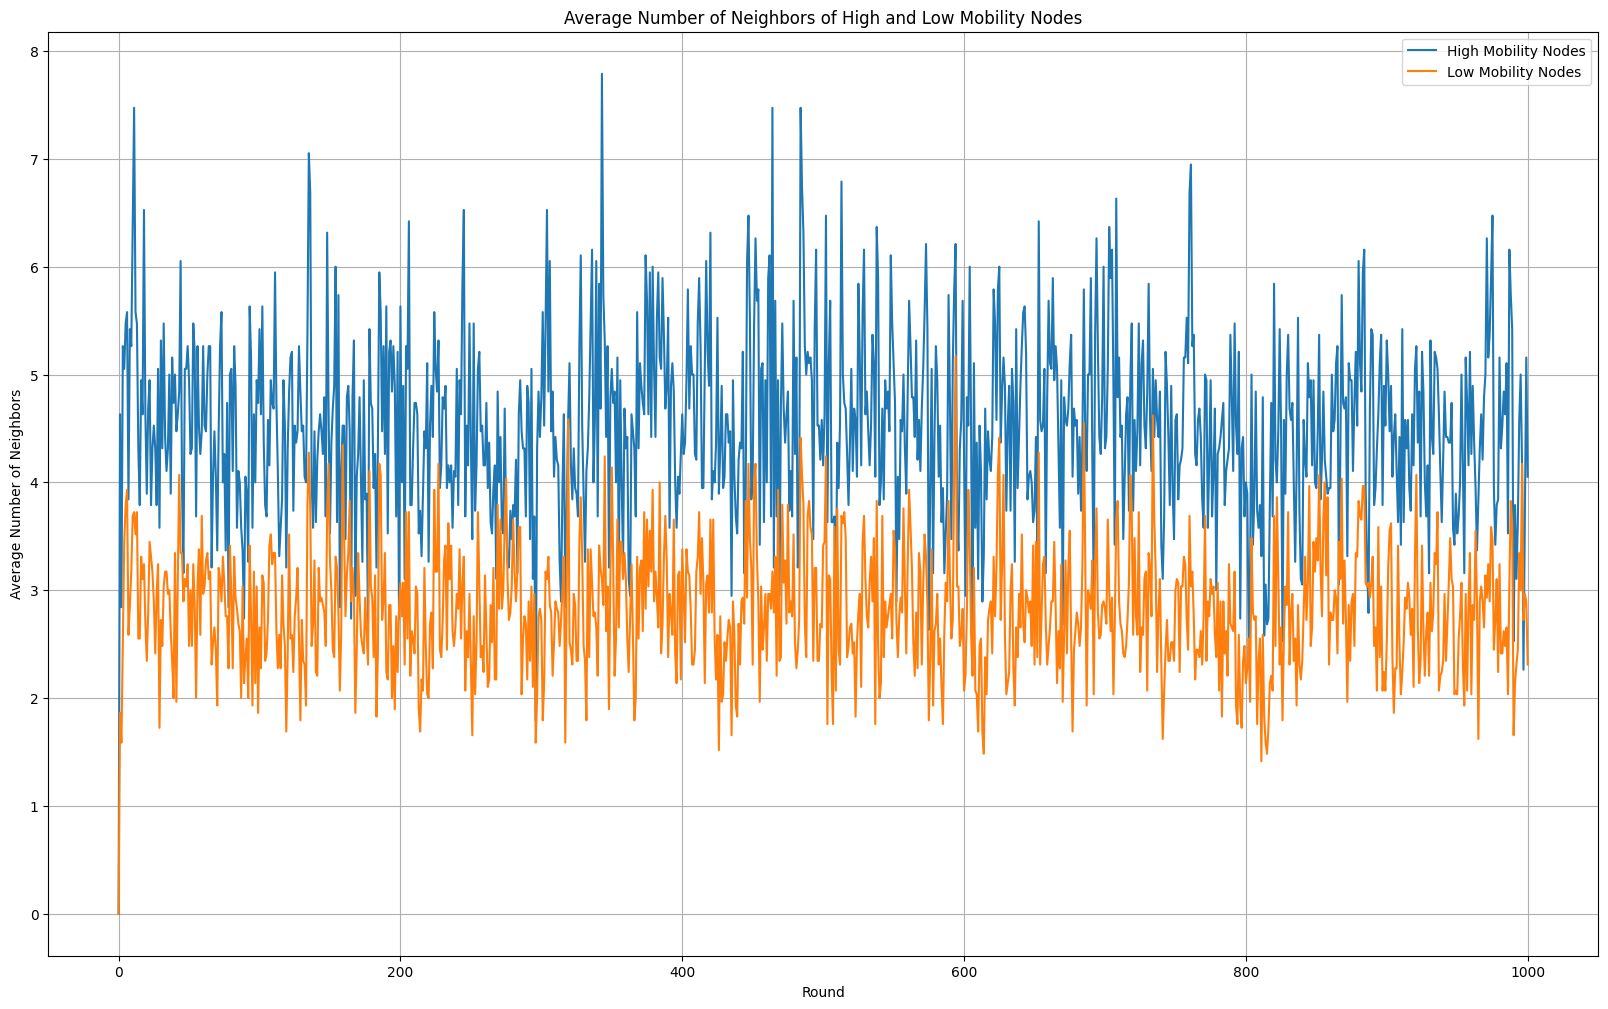

In [11]:
plt.figure(figsize=(20, 12))

average_num_neighbors_high_mobility = [np.mean([len(high_mobility_neighbors[i][node.uid]) for node in high_mobility_nodes(g)]) for i, g in enumerate(graphs)]
average_num_neighbors_low_mobility = [np.mean([len(low_mobility_neighbors[i][node.uid]) for node in low_mobility_nodes(g)]) for i, g in enumerate(graphs)]

print(average_num_neighbors_high_mobility)
print(average_num_neighbors_low_mobility)

plt.plot(average_num_neighbors_high_mobility, label="High Mobility Nodes")
plt.plot(average_num_neighbors_low_mobility, label="Low Mobility Nodes")

plt.xlabel("Round")
plt.ylabel("Average Number of Neighbors")
plt.title("Average Number of Neighbors of High and Low Mobility Nodes")
plt.legend()
plt.grid(True)
plt.show()


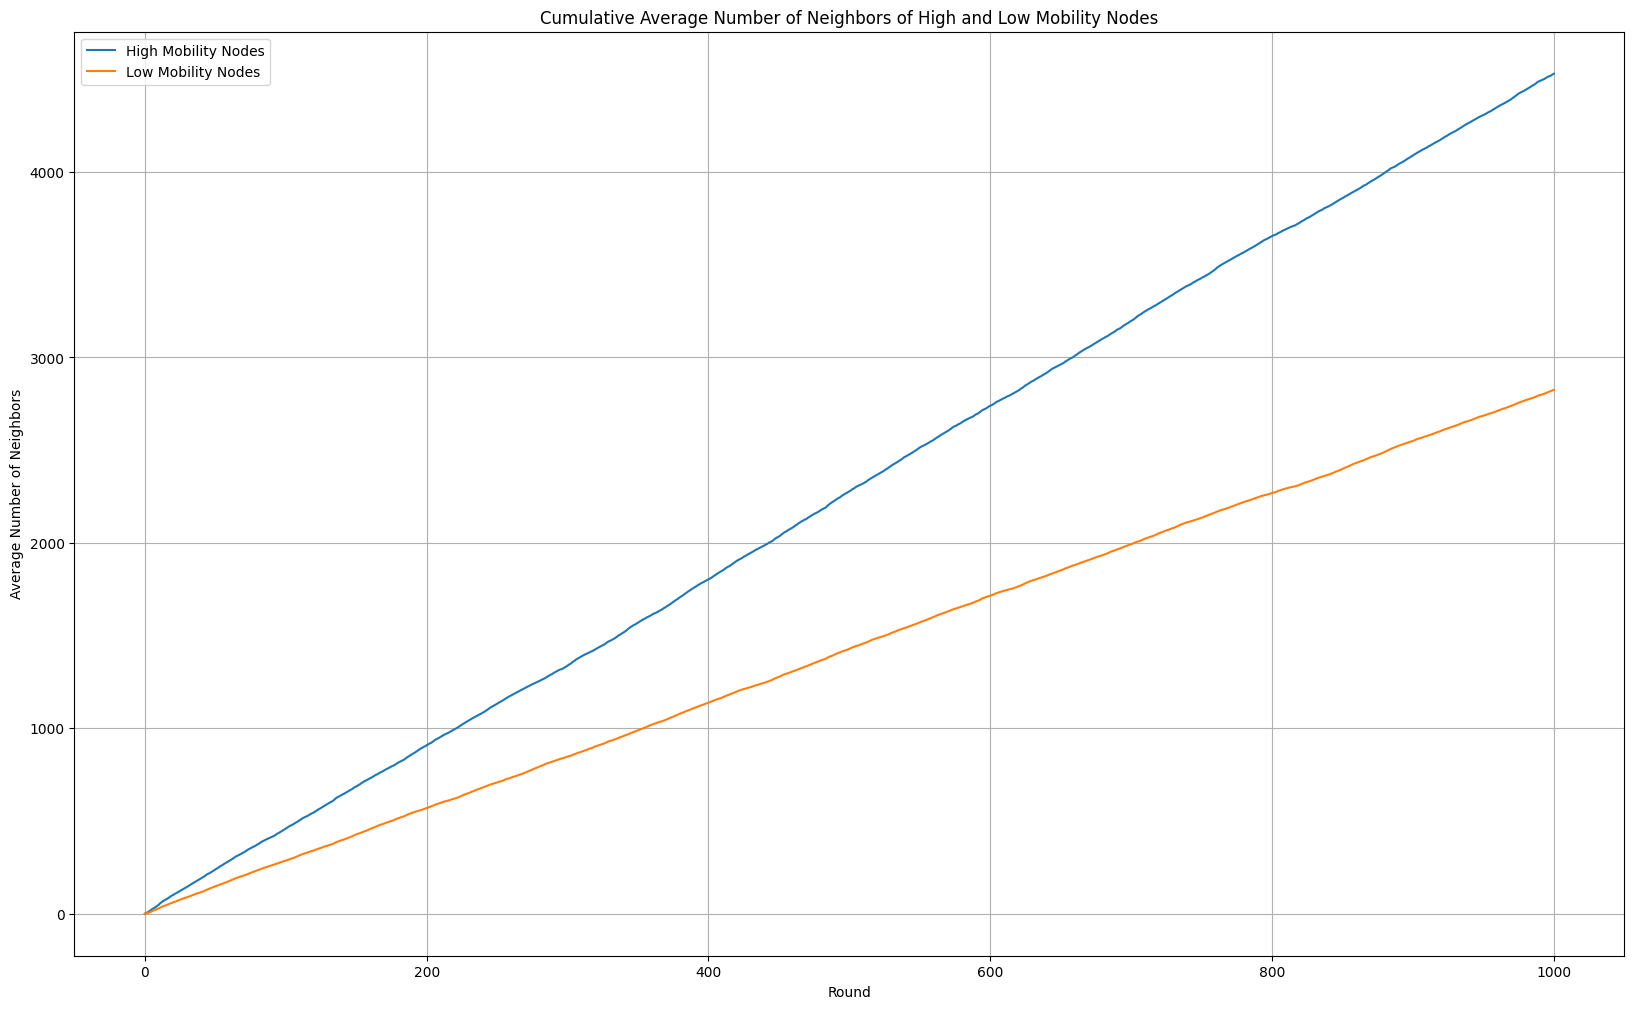

In [12]:
cumulative_num_neighbors_high_mobility = np.cumsum(np.array(average_num_neighbors_high_mobility))
cumulative_num_neighbors_low_mobility = np.cumsum(np.array(average_num_neighbors_low_mobility))

plt.figure(figsize=(20, 12))

plt.plot(cumulative_num_neighbors_high_mobility, label="High Mobility Nodes")
plt.plot(cumulative_num_neighbors_low_mobility, label="Low Mobility Nodes")

plt.xlabel("Round")
plt.ylabel("Average Number of Neighbors")
plt.title("Cumulative Average Number of Neighbors of High and Low Mobility Nodes")
plt.legend()
plt.grid(True)


[0.0, 162.6511647191459, 169.93731064217386, 194.87329353607424, 192.16087378310428, 167.38582727233032, 180.12318932730085, 186.28666334615744, 182.10704723486944, 172.59480261080398, 184.03855929971084, 167.0494674352033, 171.15205128535626, 193.96981223167964, 184.31442606510836, 192.28662834660892, 179.37777978642035, 182.16865100790548, 160.20042855763398, 166.06894266021956, 181.0971936410055, 195.3393140060794, 169.66959862504618, 184.07505088867407, 175.31884619400142, 201.79355879487488, 150.77540933102264, 183.30390376110432, 184.41661889653528, 174.07184610663845, 169.39322075247756, 178.9896947192439, 168.29985259821402, 192.31907114619608, 186.69277950216357, 241.79560217533364, 207.2434778291187, 172.4158403114811, 159.90609423974112, 176.94201419292241, 194.04021772107555, 181.8300740781214, 177.47583592443263, 181.32889346212846, 195.29751630697905, 214.39594894661937, 168.11832612431132, 193.93957616340245, 189.89010657542454, 181.22033628676996, 183.34395506103075, 17

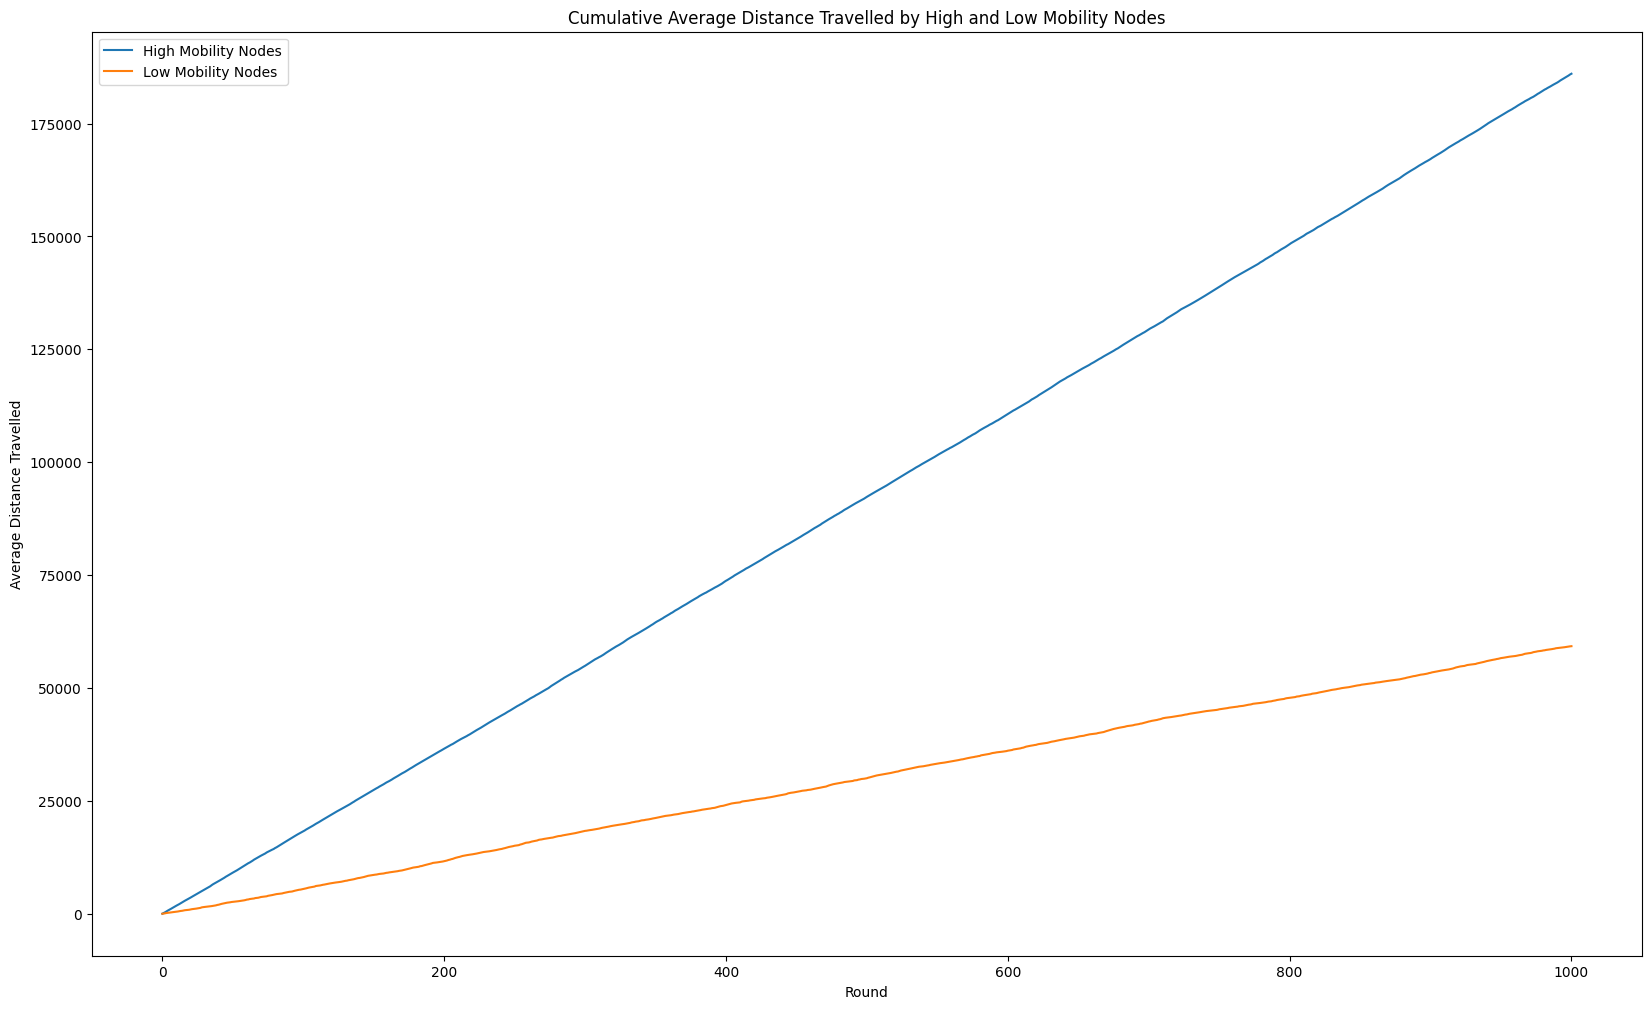

In [8]:
from decentralizepy.graphs.MobilityNode import MobilityNode


def get_node_distance_travelled(node: MobilityNode):
    return np.linalg.norm(np.array(node.pos_vec) - np.array(node.previous_pos_vec))

high_mobility_nodes_distances = [np.mean([get_node_distance_travelled(node) for node in high_mobility_nodes(g)]) for g in graphs]
low_mobility_nodes_distances = [np.mean([get_node_distance_travelled(node) for node in low_mobility_nodes(g)]) for g in graphs]
print(high_mobility_nodes_distances)
print(low_mobility_nodes_distances)

cum_high_mobility_nodes_distances = np.cumsum(np.array(high_mobility_nodes_distances))
cum_low_mobility_nodes_distances = np.cumsum(np.array(low_mobility_nodes_distances))

plt.figure(figsize=(20, 12))

plt.plot(cum_high_mobility_nodes_distances, label="High Mobility Nodes")
plt.plot(cum_low_mobility_nodes_distances, label="Low Mobility Nodes")

plt.xlabel("Round")
plt.ylabel("Average Distance Travelled")
plt.title("Cumulative Average Distance Travelled by High and Low Mobility Nodes")
plt.legend()
plt.show()